# gör backtesting på en stochastic strategy

In [138]:
import yfinance as yf
import ta
import pandas as pd
import matplotlib.pyplot as plt


In [139]:
# ticker = "ETH-USD"
ticker = "TSLA-USD"
df = yf.download(ticker, start="2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [140]:
df[df.index >= "2020-03-01"].head(30)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-06,1.046114,1.200094,0.826810,1.109129,1.109129,111066
2020-11-07,1.109129,1.200629,0.827261,1.097126,1.097126,129844
2020-11-08,1.097126,1.098143,1.062400,1.079512,1.079512,133412
2020-11-09,1.079512,1.080015,1.070853,1.077403,1.077403,182625
2020-11-10,1.077403,1.200757,0.827330,1.071106,1.071106,175186
2020-11-11,1.071106,1.080223,1.062449,1.074958,1.074958,153266
2020-11-12,1.074958,1.076842,1.069997,1.072746,1.072746,131888
2020-11-13,1.072746,1.080256,1.062136,1.074042,1.074042,310593
2020-11-14,1.074041,1.074536,1.056495,1.065136,1.065136,334127


## addera indicators

In [141]:
def indicators(df):
    df['SMA_200'] = ta.trend.sma_indicator(df['Close'], window=200)
    df['stoch_k'] = ta.momentum.stochrsi_k(df['Close'], window=10)
    df.dropna(inplace=True)
    

In [142]:
indicators(df)

In [143]:
df['Buy'] = (df['Close'] > df['SMA_200']) & (df['stoch_k'] < 0.05)

In [144]:
buydates, selldates = [],[]
buys, sells = [],[]
max_search=10

last_selldate = pd.to_datetime("1900-01-01") # last sell date to avoid selling before buying
# buydate = last_selldate
for row in range(len(df)):
    if len(selldates) > 0:
        last_selldate = selldates[-1]
    
    if df.iloc[row].Buy:
        # print('buy indicate', df.iloc[row].name)
        buyprice = df.iloc[row].Close * 0.97  # take a 3% margin
        found_buydate = False
        for k in range(1,max_search+1):
            if buyprice >= df.iloc[row+k].Low:
                buydate = df.iloc[row+k].name
                found_buydate = True
                break
            
        if not found_buydate:    
            continue   # go on with the next row
        
        if buydate > last_selldate:
            buydates.append(buydate)
            buys.append(buyprice)
            print('buy', buydate, buyprice)
            for j in range(1,max_search+1):    
                if df.iloc[row+k+j].Close > buyprice:
                    sellprice = df.iloc[row+k+j+1].Open
                    selldate = df.iloc[row+k+j+1].name
                    sells.append(sellprice)
                    selldates.append(selldate)
                    # df.iloc[row+k+j,-1] = True
                    print('sell', selldate, sellprice)
                    break
                elif j==max_search: # if no sell signal found, sell after 60 days
                    sellprice = df.iloc[row+k+j+1].Open
                    selldate = df.iloc[row+k+j+1].name
                    sells.append(sellprice)
                    selldates.append(selldate)
                    print('sell 10',selldate, sellprice)


buy 2021-11-13 00:00:00 1.0721884763240814
sell 2021-11-15 00:00:00 1.1189229488372803
buy 2021-11-18 00:00:00 1.054929324388504
sell 2021-11-20 00:00:00 1.1156940460205078
buy 2022-01-10 00:00:00 1.5097487616539
sell 2022-01-12 00:00:00 1.6737170219421387
buy 2022-02-11 00:00:00 1.5907301437854766
sell 10 2022-02-22 00:00:00 1.4732929468154907
buy 2022-04-06 00:00:00 1.437912447452545
sell 2022-04-08 00:00:00 1.4825040102005005
buy 2022-04-25 00:00:00 1.4006431186199189
sell 2022-04-27 00:00:00 1.4576280117034912
buy 2022-05-09 00:00:00 1.3738963937759399
sell 2022-05-11 00:00:00 1.3899519443511963


In [145]:
buydates

[Timestamp('2021-11-13 00:00:00'),
 Timestamp('2021-11-18 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2022-02-11 00:00:00'),
 Timestamp('2022-04-06 00:00:00'),
 Timestamp('2022-04-25 00:00:00'),
 Timestamp('2022-05-09 00:00:00')]

In [146]:
selldates

[Timestamp('2021-11-15 00:00:00'),
 Timestamp('2021-11-20 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2022-02-22 00:00:00'),
 Timestamp('2022-04-08 00:00:00'),
 Timestamp('2022-04-27 00:00:00'),
 Timestamp('2022-05-11 00:00:00')]

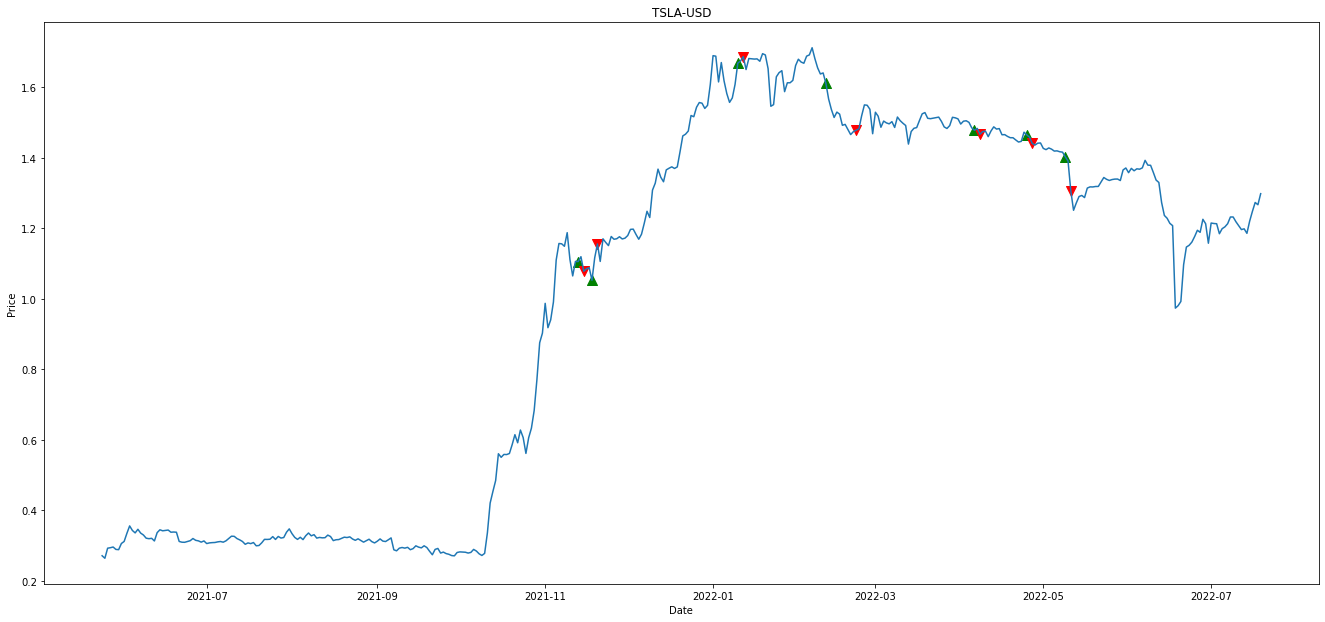

In [147]:
plt.subplot(1,1,1, xlabel='Date', ylabel='Price', title=ticker)
# set size of subplot
plt.subplots_adjust(left=0.05, right=3, top=2, bottom=0.05)
plt.plot(df['Close'])
plt.scatter(df.loc[buydates].index, df.loc[buydates].Close, marker='^', color='green', s=100)
plt.scatter(df.loc[selldates].index, df.loc[selldates].Close, marker='v', color='red', s=100)

In [148]:
buys

[1.0721884763240814,
 1.054929324388504,
 1.5097487616539,
 1.5907301437854766,
 1.437912447452545,
 1.4006431186199189,
 1.3738963937759399]

In [149]:
sells

[1.1189229488372803,
 1.1156940460205078,
 1.6737170219421387,
 1.4732929468154907,
 1.4825040102005005,
 1.4576280117034912,
 1.3899519443511963]

In [150]:
profits = pd.DataFrame([(sell - buy)/buy for sell, buy in zip(sells, buys)], columns=['profit'])
import numpy as np
print(profits)


     profit
0  0.043588
1  0.057601
2  0.108606
3 -0.073826
4  0.031011
5  0.040685
6  0.011686


In [151]:
display((profits+1).cumprod()) # cumulative profit
(df.Close.pct_change()+1).cumprod() # market development

,profit
0,1.043588
1,1.103699
2,1.223568
3,1.133237
4,1.168380
5,1.215915
6,1.230125


Date
2021-05-24         NaN
2021-05-25    0.973590
2021-05-26    1.079137
2021-05-27    1.084286
2021-05-28    1.091611
                ...   
2022-07-15    4.507333
2022-07-16    4.609838
2022-07-17    4.702934
2022-07-18    4.679163
2022-07-19    4.795195
Name: Close, Length: 422, dtype: float64